In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import yfinance as yf
import pyfolio as pf

In [2]:
activos = ['DIS']
fechas = ['2019-8-24', '2020-8-24']
stock = pd.DataFrame()
for activo in activos:
    stock[activo] = yf.Ticker(activo).history(period='1d', start=fechas[0], end=fechas[1])['Close']
stock

,DIS
Date,
2019-08-26,133.808319
2019-08-27,133.689041
2019-08-28,135.736771
2019-08-29,137.019073
2019-08-30,136.442535
...,...
2020-08-17,129.369995
2020-08-18,128.919998
2020-08-19,127.769997


In [6]:
def decision(prices, periodos_media, no_desv):
    medias=np.zeros(len(stock.index)-periodos_media)
    superior=np.zeros(len(stock.index)-periodos_media)
    inferior=np.zeros(len(stock.index)-periodos_media)
    compra=np.zeros(len(stock.index)-periodos_media)
    
    for i in range(len(prices.index)-periodos_media):
        medias[i]=prices.iloc[i:i+periodos_media,:].mean()
        superior[i]=medias[i]+no_desv*(prices.iloc[i:i+periodos_media,:].std())
        inferior[i]=medias[i]-no_desv*(prices.iloc[i:i+periodos_media,:].std())
        if (prices['DIS'][i+periodos_media] > superior[i]):
            compra[i]=-1
        elif (prices.iloc[i+periodos_media,0] < inferior[i]):
            compra[i]=1
        else:
            compra[i]=0
    
    decision = 0
    switch = 0
    
    for i in range(periodos_media,len(compra)):
        j = i - periodos_media
        if compra[j] != 0:
            decision = compra[j]
            switch = 1
        if switch != 0:
            compra[j] = decision
            if decision == 1 and prices.iloc[i,0] > medias[j]:
                decision = 0
                switch = 0
            if decision == -1 and prices.iloc[i,0] < medias[j]:
                decision = 0
                switch = 0        
    return (compra, medias, inferior, superior)

In [7]:
def get_feasible_solution(n):
    W = np.random.rand(n)
    W = W/W.sum()
    return (W)

#Función objetivo:
def OF(solucion):
    BB = decision(prices=stock, periodos_media=solucion[0], no_desv= solucion[1])
    log_ret = np.log(stock/stock.shift(1)).shift(-1)
    tabla=pd.DataFrame({'Precios':stock.iloc[solucion[0]:,0],
                        'Rend':log_ret.iloc[solucion[0]:,0],
                        'Señales':BB[0],
                        'Media':BB[1],
                        'Inferior':BB[2],
                        'Superior':BB[3]})
    retornos_estrategia = tabla['Rend']*tabla['Señales']
    
    PF = retornos_estrategia[retornos_estrategia>=0].sum()/np.abs(retornos_estrategia[retornos_estrategia<0].sum())
    return PF

def union(padre1, padre2):
    sol1 = padre1[0]
    sol2 = padre2[0]
    
    
    return ((n_media,n_desv), OF((n_media,n_desv)))
    

def mutate(solucion):
    sol = solucion[0]
    
    return ((n_media,n_desv), OF((n_media,n_desv)))

   

In [10]:
def initialPopulation(population):
    pop=[]
    for ind in range(population):
        sol = get_feasible_solution()
        pop.append((sol, OF(sol)))
    return pop

def sortGeneration(population):
    """
    Sort population by OF.
    """
    if  population==[]: 
        return []
    else:
        # para maximizar
        pivot = population[0]
        bads = sortGeneration([ind for ind in population[1:] if ind[1] < pivot[1]])
        goods = sortGeneration([ind for ind in population[1:] if ind[1] >= pivot[1]])
        return goods + [pivot] + bads
        
        # para minimizar
        # pivot = population[0]
        # bads = sortGeneration([ind for ind in population[1:] if ind[1] > pivot[1]])
        # goods = sortGeneration([ind for ind in population[1:] if ind[1] <= pivot[1]])
        # return goods + [pivot] + bads
    
    

def selectTournament(population):
    pop_size = max([2, int(0.1 * population)])
    group1 = np.random.choice(a = range(population), size = pop_size, replace = False) # 3,7,8,20,25,60
    group2 = np.random.choice(a = range(population), size = pop_size, replace = False) # 9,0
    return (min(group1), min(group2))

def GA(generations, population, n_children, p_mutation):
    """
    Genetic algorithm search
    """

    pop = initialPopulation(population)
    overall_best = []
    generation = 1
    while generation <= generations:
        children = []
        pop = sortGeneration(pop)
        overall_best.append(pop[0][1])
        for aux in range(n_children):                
            pos = selectTournament(population)
            parent1 = pop[pos[0]]
            parent2 = pop[pos[1]]
            
            child = union(parent1, parent2)

            if np.random.rand() <= p_mutation:
                child = mutate(child)
            children.append(child)
        pop = pop[:(population - n_children)] + children
        generation += 1

    pop = sortGeneration(pop)
    overall_best.append(pop[0][1])
    best_config_found = pop[0][0]
    best_OF_found = OF(best_config_found)
    return {'best_w':best_config_found, 'best_fo':best_OF_found,'overall_best':overall_best}

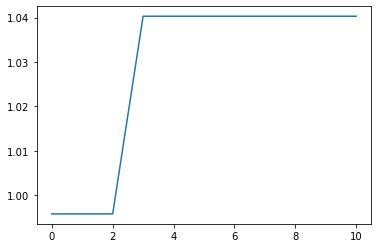

In [11]:
Example = GA(10, 100, 40, 0.05)
plt.plot(Example['overall_best'])
plt.show()

# Backtesting